# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Functions definition

In [2]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda
from Fonctions import get_3D_budget_xarr
from Fonctions import get_3D_xarr
from Fonctions import get_3D_SW_xarr
from Fonctions import get_3D_LW_xarr

In [3]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [4]:
def RMSE_emulator(pc1, pc2, pc3, pc4, pc5, variable) : 
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    E_pc1 = []
    E_pc2 = []
    E_pc3 = []
    E_pc4 = []
    E_pc5 = []
    E_tmp = []

    for i in pc1:
        tmp = (i-U_obs[0])**2
        E_pc1.append(tmp)
    
    for j in pc2:
        tmp = (j-U_obs[1])**2
        E_pc2.append(tmp)

    for k in pc3:
        tmp = (k-U_obs[2])**2
        E_pc3.append(tmp)
    
    for l in pc4:
        tmp = (l-U_obs[3])**2
        E_pc4.append(tmp)
    
    for m in pc5:
        tmp = (m-U_obs[4])**2
        E_pc5.append(tmp)

    for n in range(0,len(E_pc1),1) :    
        tmp = E_pc1[n]+E_pc2[n]+E_pc3[n]+E_pc4[n]+E_pc5[n]
        E_tmp.append(tmp/5)

    
    E = sqrt(E_tmp)
    
    
    return E

In [5]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [6]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

# Settings

In [7]:
variable = 'tas'
TITLE = 'Temperature ($K$)'
ylabel = 'RMSE [PPE - BEST]'

# CFMIP models

In [8]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [9]:
U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')

path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

filename = 'U_MRI_'+variable+'.npy'
E_MRI = Error(path, filename, U_obs)

filename = 'U_CAN_'+variable+'.npy'
E_CAN = Error(path, filename, U_obs)

filename = 'U_MIROC_'+variable+'.npy'
E_MIROC = Error(path, filename, U_obs)

filename = 'U_HadGEM3_'+variable+'.npy'
E_HadGEM3 = Error(path, filename, U_obs)

filename = 'U_IPSL_'+variable+'.npy'
E_IPSL = Error(path, filename, U_obs)

filename = 'U_BCC_'+variable+'.npy'
E_BCC = Error(path, filename, U_obs)

In [10]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

# official, membre p1

In [11]:
pc1_obs = U_obs[0]
pc2_obs = U_obs[1]
pc3_obs = U_obs[2]
pc4_obs = U_obs[3]
pc5_obs = U_obs[4]

pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+variable+'.npy')
pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+variable+'.npy')
pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+variable+'.npy')
pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+variable+'.npy')
pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+variable+'.npy')

p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [12]:
E_p1_tmp = (pc1_p1-pc1_obs)**2 + (pc2_p1-pc2_obs)**2 + (pc3_p1-pc3_obs)**2 + (pc4_p1-pc4_obs)**2 + (pc5_p1-pc5_obs)**2
E_p1 = sqrt(E_p1_tmp/5)
        
print(E_p1)

2.307061427638823


# PPE

In [13]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')

E_PPE_df = pd.DataFrame()
E_PPE_df['Fdbck'] = Fdbck_PPE
E_PPE_df['RMSE'] = E_PPE
E_PPE_df

,Fdbck,RMSE
0,-0.825236,1.436106
1,-1.659636,3.114970
2,-1.215000,1.914948
3,-1.321641,2.843414
4,-0.750397,1.839331
...,...,...
97,-1.516367,2.703765
98,-1.584491,2.912230
99,-1.474525,2.903634
100,-1.445422,2.691245


# Search for best models : initial guess for optimization

In [14]:
E_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_"+variable+".npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")


E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred)
E_multilinreg_pred_df['E_multilinreg_pred'] = E_multilinreg_pred
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred[0:100000]
E_multilinreg_pred_df = E_multilinreg_pred_df.drop([0], axis=1)
E_multilinreg_pred_df

,E_multilinreg_pred,Fdbck_pred
0,2.101710,-1.499698
1,2.167075,-1.339351
2,2.380851,-1.323732
3,1.970012,-1.541909
4,2.682910,-1.346961
...,...,...
99995,2.825198,-1.453679
99996,2.573607,-1.410350
99997,2.214644,-1.296397
99998,2.299727,-1.299809


In [15]:
E_multilinreg_pred_df['Fdbck_pred_round'] = E_multilinreg_pred_df['Fdbck_pred'].round(decimals=2)
E_multilinreg_pred_df = E_multilinreg_pred_df.set_index('Fdbck_pred_round')
E_multilinreg_pred_df['members'] = range(0,100000,1) 
E_multilinreg_pred_df        

,E_multilinreg_pred,Fdbck_pred,members
Fdbck_pred_round,,,
-1.50,2.101710,-1.499698,0
-1.34,2.167075,-1.339351,1
-1.32,2.380851,-1.323732,2
-1.54,1.970012,-1.541909,3
-1.35,2.682910,-1.346961,4
...,...,...,...
-1.45,2.825198,-1.453679,99995
-1.41,2.573607,-1.410350,99996
-1.30,2.214644,-1.296397,99997


In [16]:
new_df=pd.DataFrame()
new_df['E_multilinreg_pred_best'] = E_multilinreg_pred_df['E_multilinreg_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
new_df

,Fdbck_pred_round,E_multilinreg_pred_best
0,-1.99,2.722538
1,-1.95,3.030007
2,-1.93,3.279677
3,-1.91,3.128875
4,-1.90,2.599203
...,...,...
108,-0.86,1.841607
109,-0.85,1.655666
110,-0.82,2.151584
111,-0.80,1.794538


In [17]:
list_RMSE = new_df['E_multilinreg_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_pred_df['E_multilinreg_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_multilinreg_pred_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
new_df

,Fdbck_pred_round,E_multilinreg_pred_best,Fdbck_pred,members
0,-1.99,2.722538,-1.985956,35649
1,-1.95,3.030007,-1.953341,47523
2,-1.93,3.279677,-1.927200,30599
3,-1.91,3.128875,-1.914973,74150
4,-1.90,2.599203,-1.902838,2836
...,...,...,...,...
108,-0.86,1.841607,-0.859893,47246
109,-0.85,1.655666,-0.852741,60906
110,-0.82,2.151584,-0.820649,57260
111,-0.80,1.794538,-0.803475,76973


# First Optimization

In [18]:
# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred
    



In [19]:
# FONCTION JACOBIAN

def jacobian(x, variable) :
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(5)
    
    jac = (A/B)*D
    
    return jac

#def objective(x, x0):
#    fdb = em_fdb(x)
#    fdb_x0 = em_fdb(x0)
#    RMSE = function_RMSE_emulator(x)
#    E_tmp = 1+(fdb-fdb_x0)**2
#    E = E_tmp*RMSE
#    return E

# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variable) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
        #if em_fdb(x0)<-1.8 : 
        #    ind = 0.0001
        #elif em_fdb(x0)>-1.0:
        #    ind = 0.0001
        #else:
        #    ind = 0.0001
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_emulator(x0, variable)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_emulator(sol.x, variable)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
        #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
        #    sol_list.append(tmp_fun)
        #    sol_fdbck.append(tmp_fdbck)
        #else :
        #    print('\n ERROR \n')
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [20]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [21]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
xlim

array([[ 6.0e-02,  2.8e-01],
       [ 5.0e-01,  3.0e+00],
       [ 5.0e-01,  3.0e+00],
       [ 0.0e+00,  3.0e+01],
       [-5.0e-01, -1.0e-02],
       [ 0.0e+00,  1.0e+01],
       [ 0.0e+00,  1.0e+01],
       [ 5.0e-04,  1.0e-02],
       [ 5.0e-05,  1.0e-03],
       [ 5.0e-04,  1.0e-02],
       [ 1.0e-08,  1.0e-06],
       [ 5.0e-06,  1.0e-04],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-01,  6.0e+00],
       [ 1.0e-01,  6.0e+00],
       [ 3.0e-05,  7.0e-05],
       [ 8.0e-05,  6.0e-04],
       [ 2.0e-06,  1.0e-05],
       [ 3.0e-05,  1.2e-04],
       [-5.0e+00, -1.0e+00],
       [-5.0e+01, -2.5e+01],
       [ 1.0e-02,  1.0e-01],
       [ 0.0e+00,  2.0e+01],
       [ 1.0e-05,  1.0e-04],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 2.0e-01,  1.0e+01]])

In [22]:
sol_df = Optimization(x_best, 0.0001, xlim, variable)
sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3601084255236358
            Iterations: 10
            Function evaluations: 24
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4074992935718642
            Iterations: 8
            Function evaluations: 19
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.399411766531614
            Iterations: 8
            Function evaluations: 19
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2553161019946157
            Iterations: 9
            Function evaluations: 20
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2964689930070679
            Iterations: 10
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2337238160002533
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7163314861481308
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0765745973730059
            Iterations: 4
            Function evaluations: 19
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2729316166288895
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9219206511118603
            Iterations: 4
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.34629815175324874
            Iterations: 9
            Function evaluations: 26
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3228926189100758
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6595288737690673
            Iterations: 4
            Function evaluations: 8
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6540713914115422
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5561631979939062
            Iterations: 6
            Function evaluat

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.360108,-1.985856,0.28,0.500000,2.430619,27.096979,-0.010000,1.847803e-13,1.300650e+00,0.000500,...,-2.168065,-25.000044,0.092961,12.575175,0.00001,1.000000,0.500000,0.500419,0.500000,6.818347
1,1.407499,-1.953241,0.28,0.500000,2.266876,16.639394,-0.010000,5.171925e-13,3.854408e+00,0.000500,...,-2.152371,-30.179321,0.083226,16.792451,0.00001,0.890890,0.500000,0.533220,0.500000,4.568282
2,1.399412,-1.927100,0.28,0.500000,2.552176,24.858407,-0.010000,0.000000e+00,1.983192e-01,0.000500,...,-1.440632,-48.497398,0.086481,8.517909,0.00001,1.000000,0.500000,0.500000,0.500000,7.720874
3,1.255316,-1.914873,0.28,0.500000,2.385808,16.208560,-0.010000,1.650479e-13,1.534165e-15,0.000500,...,-1.464753,-39.737636,0.087995,1.566911,0.00001,1.000000,0.500000,0.514327,0.500000,3.060190
4,1.296469,-1.902738,0.28,0.500000,2.476609,25.076240,-0.010000,0.000000e+00,4.497913e+00,0.000500,...,-3.904908,-26.646446,0.064971,13.935066,0.00001,1.000000,0.500000,0.692845,0.500000,2.574555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.809897,-0.859993,0.28,2.757378,0.768816,22.333575,-0.226637,2.435923e+00,7.532791e+00,0.000500,...,-4.145078,-46.564664,0.010000,18.203737,0.00010,0.869120,0.620791,0.995130,0.822569,5.226275
109,0.323780,-0.852841,0.28,1.675056,1.644735,14.274276,-0.010000,8.639063e-15,7.577492e+00,0.000500,...,-2.549276,-49.359206,0.010000,0.016607,0.00010,0.651836,0.500000,0.869454,0.500000,6.397285
110,0.747365,-0.820749,0.28,0.500000,2.896682,15.786260,-0.010000,8.585460e-15,2.742636e+00,0.010000,...,-1.000000,-25.373790,0.010000,0.873078,0.00010,0.502354,0.500000,1.000000,0.582425,2.981334
111,0.555579,-0.803574,0.28,1.010910,2.217242,16.672071,-0.010000,2.655900e-16,3.881032e-01,0.000500,...,-2.078220,-42.313626,0.010000,3.565035,0.00010,0.500000,0.500000,1.000000,0.500000,4.222259


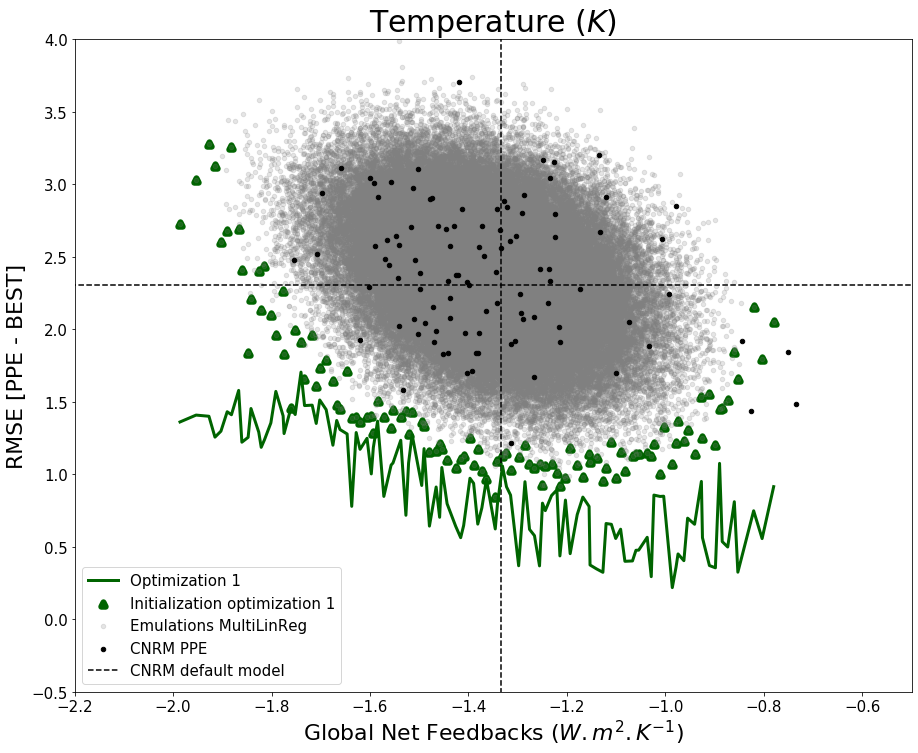

In [23]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

# sol.x smoothing

In [24]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

In [25]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985856,0.280000,0.500000,2.430619,27.096979,-0.010000,1.847803e-13,1.300650,0.000500,0.00100,...,-2.168065,-25.000044,0.092961,12.575175,0.000010,1.000000,0.500000,0.500419,0.500000,6.818347
1,-1.953241,0.280000,0.500000,2.379137,21.308543,-0.010000,3.047913e-13,2.301946,0.000500,0.00100,...,-2.210163,-25.674532,0.090389,12.382421,0.000010,0.986935,0.502276,0.510873,0.500096,6.765810
2,-1.927100,0.280000,0.500000,2.439259,20.641192,-0.010000,1.705601e-13,1.062762,0.000500,0.00100,...,-2.252377,-26.339006,0.087806,12.191626,0.000010,0.973883,0.504613,0.521298,0.500194,6.713647
3,-1.914873,0.280000,0.500000,2.450100,20.587942,-0.010000,8.252397e-14,1.174058,0.000500,0.00100,...,-2.294809,-26.983910,0.085204,12.004736,0.000010,0.960858,0.507069,0.531663,0.500297,6.662203
4,-1.902738,0.271181,0.500000,2.383310,18.483512,-0.010000,1.011756e-12,2.248956,0.000500,0.00100,...,-2.337543,-27.600560,0.082574,11.823674,0.000011,0.947877,0.509696,0.541936,0.500406,6.611780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.859993,0.280000,1.953056,1.411846,15.754752,-0.118319,1.217962e+00,5.697924,0.001381,0.00005,...,-2.601552,-43.907893,0.010000,8.255106,0.000100,0.568291,0.510653,0.934655,0.769992,7.324742
109,-0.852841,0.280000,1.651872,1.738742,16.667097,-0.064159,6.089809e-01,6.357603,0.002875,0.00005,...,-2.579809,-44.742993,0.010000,8.530947,0.000100,0.560146,0.509886,0.945671,0.794536,7.442264
110,-0.820749,0.280000,0.921491,2.413835,15.629717,-0.010000,6.518893e-15,3.362717,0.005250,0.00005,...,-2.556629,-45.608094,0.010000,8.821127,0.000100,0.551727,0.508997,0.956818,0.820026,7.565237
111,-0.803574,0.280000,1.288673,2.132942,19.623813,-0.097912,3.967596e-01,2.437803,0.002876,0.00005,...,-2.532446,-46.493778,0.010000,9.121036,0.000100,0.543119,0.508021,0.968050,0.846169,7.691991


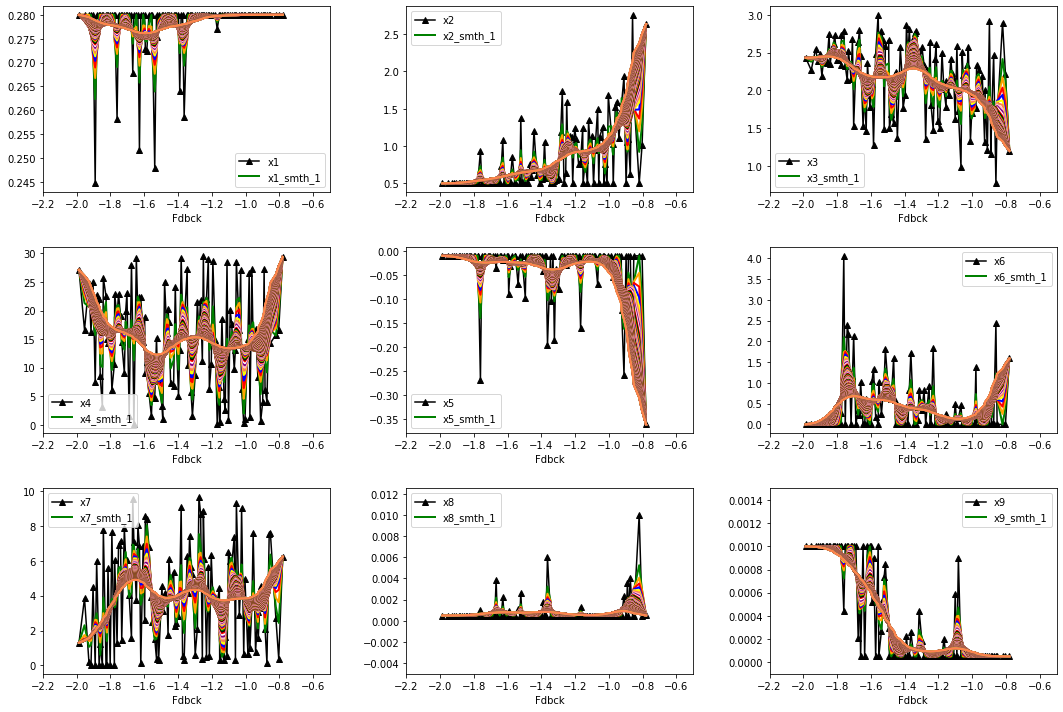

In [26]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

# Second Optimization : initialized with smoothed sol.x

In [27]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.28      , 0.5       , 2.43061885, ..., 0.50041892, 0.5       ,
        6.81834686],
       [0.27975713, 0.50139752, 2.43375085, ..., 0.51087347, 0.5000958 ,
        6.76581039],
       [0.27951913, 0.50282663, 2.43680888, ..., 0.5212983 , 0.5001939 ,
        6.71364659],
       ...,
       [0.27999992, 2.37763168, 1.32601257, ..., 0.95681846, 0.82002586,
        7.56523709],
       [0.27999996, 2.50454589, 1.26364019, ..., 0.96804979, 0.84616908,
        7.69199094],
       [0.28      , 2.63287138, 1.2006009 , ..., 0.97932258, 0.87264602,
        7.82068029]])

In [28]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_emulator(i, variable)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985856,1.360108
1,-1.953241,1.347337
2,-1.927100,1.336241
3,-1.914873,1.326808
4,-1.902738,1.318975
...,...,...
108,-0.859993,0.665079
109,-0.852841,0.721922
110,-0.820749,0.782917
111,-0.803574,0.847206


In [29]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variable)
sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3601084255552898
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3473367163648955
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3362415014087858
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3268078377375732
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3189750772410693
            Iterations: 1
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9402985350864924
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9225792487650748
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9050942359902858
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8878251094993567
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8707680047034468
            Iterations: 1
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45378972107035187
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4450909728524439
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4371265587086847
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42997066078117424
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4236575832318977
            Iterations: 1
            Function evalu

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.360108,-1.985856,0.280000,0.500000,2.430619,27.096979,-0.010000,1.847803e-13,1.300650,0.000500,...,-2.168065,-25.000044,0.092961,12.575175,0.000010,1.000000,0.500000,0.500419,0.500000,6.818347
1,1.347337,-1.971725,0.279757,0.501398,2.433751,26.109032,-0.010675,2.114245e-02,1.434011,0.000502,...,-2.210163,-25.674532,0.090389,12.382421,0.000010,0.986935,0.502276,0.510873,0.500096,6.765810
2,1.336242,-1.957647,0.279519,0.502827,2.436809,25.133468,-0.011362,4.289074e-02,1.568034,0.000505,...,-2.252377,-26.339006,0.087806,12.191626,0.000010,0.973883,0.504613,0.521298,0.500194,6.713647
3,1.326808,-1.943674,0.279291,0.504317,2.439714,24.182242,-0.012072,6.582005e-02,1.703363,0.000507,...,-2.294809,-26.983910,0.085204,12.004735,0.000010,0.960858,0.507069,0.531663,0.500297,6.662203
4,1.318975,-1.929851,0.279075,0.505897,2.442377,23.266470,-0.012815,9.044499e-02,1.840602,0.000510,...,-2.337543,-27.600559,0.082574,11.823673,0.000011,0.947876,0.509696,0.541936,0.500406,6.611780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.624267,-0.834523,0.280000,2.042180,1.484346,23.445803,-0.181458,8.866940e-01,5.217923,0.000500,...,-2.594853,-43.886151,0.010000,8.235031,0.000100,0.573098,0.500000,0.935119,0.728530,7.334452
109,0.685608,-0.821102,0.280000,2.158450,1.427703,24.841408,-0.207485,1.001528e+00,5.450533,0.000500,...,-2.573119,-44.720645,0.010000,8.510448,0.000100,0.565652,0.500000,0.946032,0.751039,7.451603
110,0.754269,-0.807546,0.280000,2.278664,1.369233,26.297357,-0.234390,1.120432e+00,5.693933,0.000500,...,-2.549948,-45.585115,0.010000,8.800179,0.000100,0.557956,0.500000,0.957074,0.774430,7.574191
111,0.828781,-0.793896,0.280000,2.401644,1.309498,27.794899,-0.261902,1.242165e+00,5.944735,0.000500,...,-2.525773,-46.470156,0.010000,9.099624,0.000100,0.550087,0.500000,0.968200,0.798443,7.700547


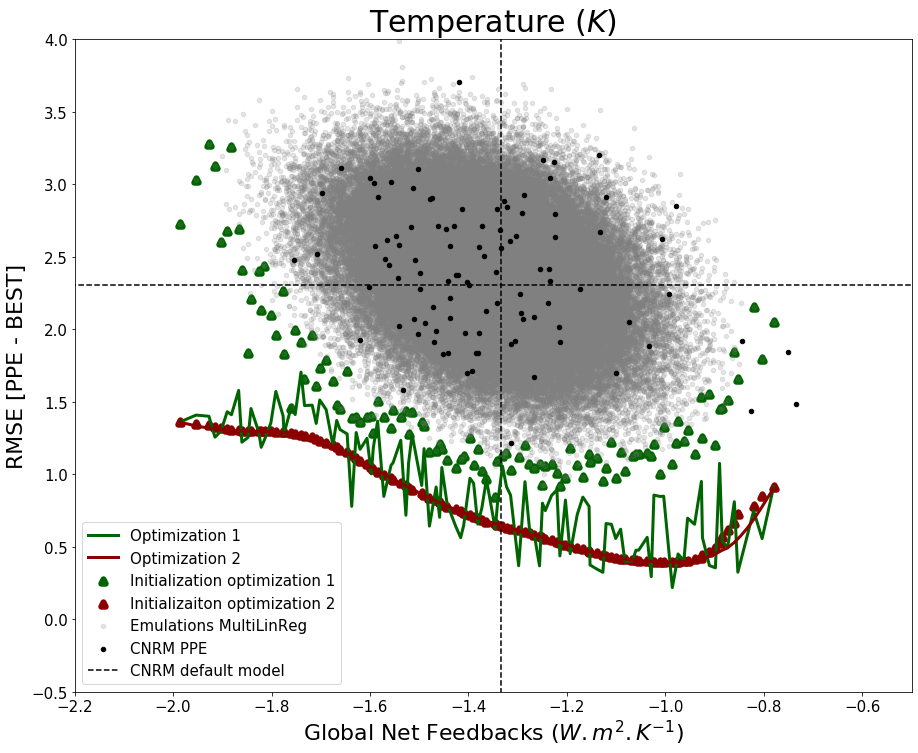

In [30]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 'Initializaiton optimization 2', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [31]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy', Fdbck_optim2)

# Selection des parametrisations à tester

In [32]:
select = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy')
list_index = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select_indexes.npy')
df_select = pd.DataFrame(select, columns=list_index).drop('sol_fun', axis=1)
df_select

,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,x9_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,-1.985756,0.077966,0.707847,1.342598,29.587336,-0.010000,7.143065,2.921715,0.000500,0.001000,...,-2.446023,-25.226770,0.069563,13.385950,0.000010,0.812696,0.500000,0.637957,0.500000,5.638358
1,-1.793526,0.117211,0.780585,1.458628,15.797065,-0.062336,3.922113,3.921972,0.002777,0.000814,...,-3.082096,-33.126637,0.064929,12.024501,0.000035,0.815730,0.678061,0.744172,0.539215,4.417620
2,-1.639356,0.152330,0.910553,1.595681,12.928419,-0.067871,2.424977,4.610691,0.003616,0.000669,...,-2.911492,-32.347723,0.052422,10.015403,0.000052,0.858959,0.666443,0.791925,0.566553,4.202803
3,-1.489737,0.178820,1.042084,1.647094,15.107814,-0.075286,1.700242,4.785704,0.004851,0.000566,...,-2.623568,-34.081485,0.038990,9.026731,0.000065,0.817358,0.665495,0.812169,0.570474,3.401959
4,-1.339177,0.200599,1.137667,1.700507,16.354994,-0.085945,1.539973,4.211867,0.005679,0.000481,...,-2.505365,-35.850443,0.027654,8.276984,0.000072,0.789666,0.669841,0.804791,0.585565,3.290619
5,-1.189214,0.196247,1.476706,1.575335,13.113172,-0.106827,1.492097,4.501310,0.005567,0.000404,...,-2.544657,-37.133155,0.022707,5.488733,0.000077,0.734181,0.649595,0.799212,0.634754,3.707331
6,-1.039710,0.192539,1.760590,1.285336,11.040241,-0.143078,1.853451,4.159379,0.005265,0.000287,...,-2.641183,-39.145415,0.014204,4.295963,0.000080,0.651121,0.627593,0.789305,0.687241,4.482628
7,-0.873525,0.200238,2.194593,1.132844,18.420054,-0.279349,1.605363,4.910546,0.005240,0.000176,...,-2.763235,-42.810276,0.010739,6.170077,0.000091,0.584788,0.566298,0.890971,0.782048,5.819485
8,-0.779930,0.227325,2.645311,1.087184,29.392837,-0.387431,1.723334,6.251026,0.005191,0.000050,...,-2.508373,-47.390254,0.010000,9.405416,0.000100,0.526937,0.526760,0.986168,0.858967,7.763388


In [33]:
x = []
sol_fun=[]
for j in range(0,len(df_select), 1) :
    df = df_select.iloc[j]
    for i in range(1,31,1):        
        x.append(df['x'+str(i)+'_smth_0'])
    
    sol_fun_tmp = function_RMSE_emulator(x, variable)
    sol_fun.append(sol_fun_tmp)
    x = []
    
df_select['sol_fun'] = sol_fun
df_select

,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,x9_smth_0,...,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0,sol_fun
0,-1.985756,0.077966,0.707847,1.342598,29.587336,-0.010000,7.143065,2.921715,0.000500,0.001000,...,-25.226770,0.069563,13.385950,0.000010,0.812696,0.500000,0.637957,0.500000,5.638358,2.909705
1,-1.793526,0.117211,0.780585,1.458628,15.797065,-0.062336,3.922113,3.921972,0.002777,0.000814,...,-33.126637,0.064929,12.024501,0.000035,0.815730,0.678061,0.744172,0.539215,4.417620,2.434287
2,-1.639356,0.152330,0.910553,1.595681,12.928419,-0.067871,2.424977,4.610691,0.003616,0.000669,...,-32.347723,0.052422,10.015403,0.000052,0.858959,0.666443,0.791925,0.566553,4.202803,1.959447
3,-1.489737,0.178820,1.042084,1.647094,15.107814,-0.075286,1.700242,4.785704,0.004851,0.000566,...,-34.081485,0.038990,9.026731,0.000065,0.817358,0.665495,0.812169,0.570474,3.401959,1.713032
4,-1.339177,0.200599,1.137667,1.700507,16.354994,-0.085945,1.539973,4.211867,0.005679,0.000481,...,-35.850443,0.027654,8.276984,0.000072,0.789666,0.669841,0.804791,0.585565,3.290619,1.534563
5,-1.189214,0.196247,1.476706,1.575335,13.113172,-0.106827,1.492097,4.501310,0.005567,0.000404,...,-37.133155,0.022707,5.488733,0.000077,0.734181,0.649595,0.799212,0.634754,3.707331,1.575818
6,-1.039710,0.192539,1.760590,1.285336,11.040241,-0.143078,1.853451,4.159379,0.005265,0.000287,...,-39.145415,0.014204,4.295963,0.000080,0.651121,0.627593,0.789305,0.687241,4.482628,1.580550
7,-0.873525,0.200238,2.194593,1.132844,18.420054,-0.279349,1.605363,4.910546,0.005240,0.000176,...,-42.810276,0.010739,6.170077,0.000091,0.584788,0.566298,0.890971,0.782048,5.819485,1.421132
8,-0.779930,0.227325,2.645311,1.087184,29.392837,-0.387431,1.723334,6.251026,0.005191,0.000050,...,-47.390254,0.010000,9.405416,0.000100,0.526937,0.526760,0.986168,0.858967,7.763388,1.360300


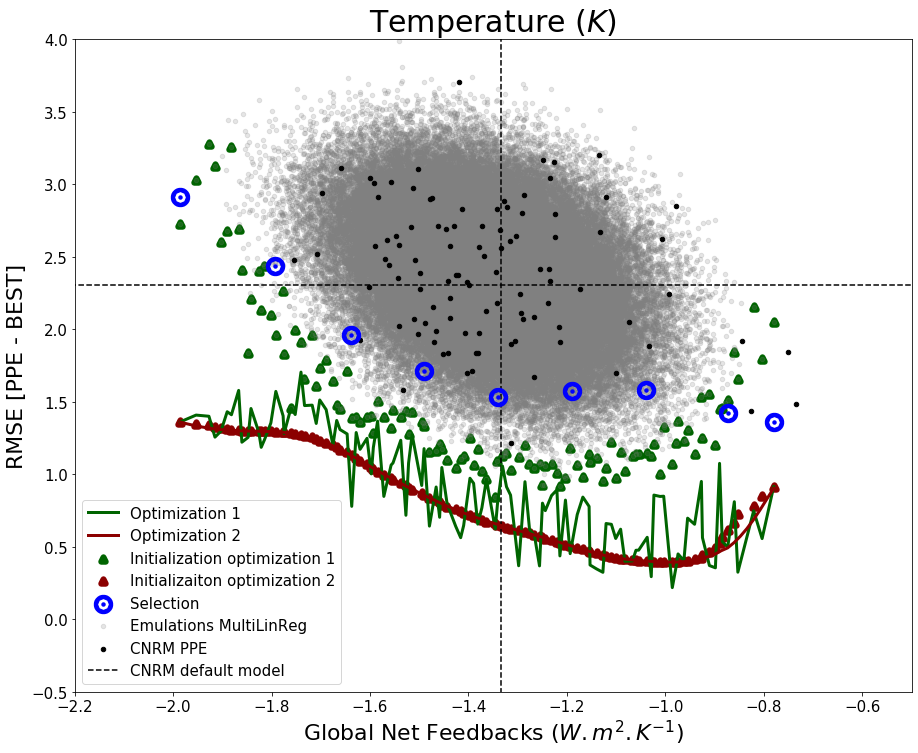

In [34]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', linewidth=3, ax = ax)

df_select.plot(kind='scatter', x='Fdbck', y='sol_fun', color='blue', marker='o', linewidth=15, 
               zorder=10, ax=ax)


E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 
                   'Initializaiton optimization 2', 'Selection', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

# Simulations ARPEGE-Climat de la selection

In [35]:
nb_p_list_selection = ['p801', 'p802', 'p803', 'p804','p805', 'p806', 'p807', 'p808']
len(nb_p_list_selection)

8

In [36]:
PC_PPE_selection = {}

for i in nb_p_list_selection :
    PC_PPE_selection[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+variable+'.npy')
    
PC_PPE_selection

{'p801': array([ 1.2245613, -1.5081006,  1.9946977,  1.5230054,  1.2770219],
       dtype=float32),
 'p802': array([ 0.77490926, -0.33094734,  1.1236016 ,  1.4312241 , -0.70678806],
       dtype=float32),
 'p803': array([ 0.5520675 ,  0.62216014,  0.30210823,  0.6068284 , -1.2610977 ],
       dtype=float32),
 'p804': array([-0.3746975 , -1.1988878 ,  0.4115676 ,  0.13284907, -0.84948814],
       dtype=float32),
 'p805': array([-0.61672276, -0.45078278, -0.16771463,  0.2374061 , -2.0084932 ],
       dtype=float32),
 'p806': array([-0.37829357,  0.02391997, -0.6139136 , -0.62732065, -2.0032966 ],
       dtype=float32),
 'p807': array([-0.49082744, -0.5455982 , -1.1729612 , -1.0544798 , -0.47725782],
       dtype=float32),
 'p808': array([-0.567737  , -1.5143274 , -1.6198429 ,  0.9685622 , -0.09063481],
       dtype=float32)}

In [37]:
E_PPE_selection = []
for i in nb_p_list_selection :
    pc1 = PC_PPE_selection[i][0]
    pc2 = PC_PPE_selection[i][1]
    pc3 = PC_PPE_selection[i][2]
    pc4 = PC_PPE_selection[i][3]
    pc5 = PC_PPE_selection[i][4]
    
    E_PPE_selection.append(Error_emulator(pc1, pc2, pc3, pc4, pc5, variable))

E_PPE_selection.append(10)
E_PPE_selection

[3.29630845380309,
 2.274179879055844,
 1.7576126125260205,
 2.0683901097911503,
 1.5077927530660484,
 1.3473675284584061,
 2.1032187405735407,
 2.61973052748202,
 10]

In [38]:
Fdbck_tmp = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/Net_feedbacks.npy").tolist()
Fdbck_PPE_selection = []
for i in Fdbck_tmp :
    Fdbck_PPE_selection.append(i)
    
Fdbck_PPE_selection.append(10)
Fdbck_PPE_selection

[-1.7078146537144978,
 -1.751123030980428,
 -1.6688634951909382,
 -1.5909866491953533,
 -1.4788317680358887,
 -1.2614845037460327,
 -0.9229870438575745,
 -0.7231393257776896,
 10]

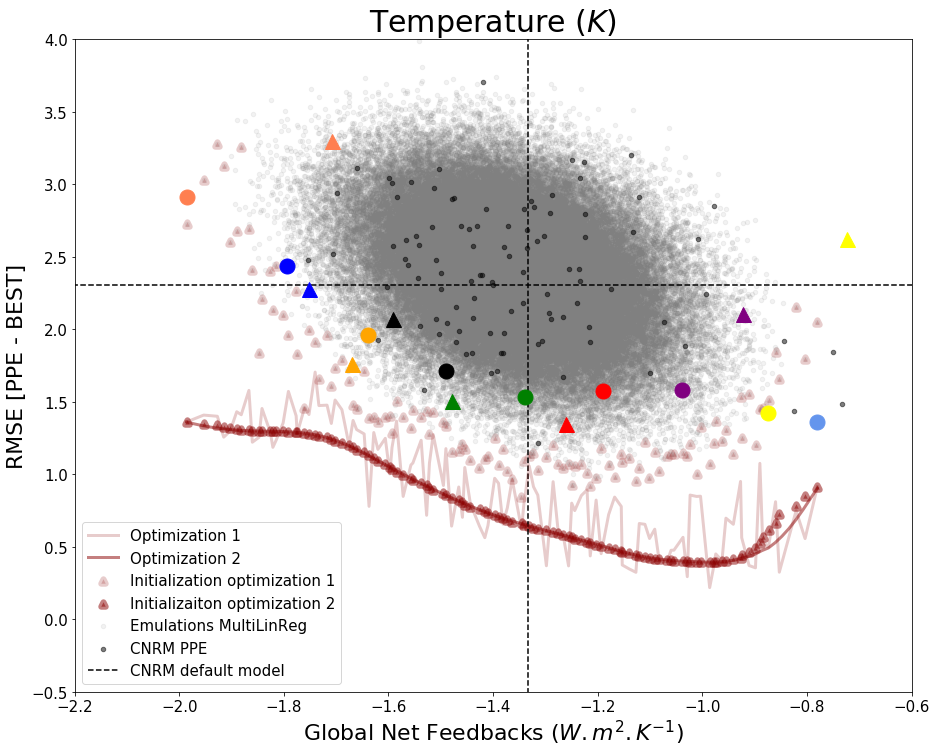

In [39]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkred', alpha=0.2,
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', alpha=0.5,
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.2,
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.5, linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), alpha=0.5,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')
legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 
                   'Initializaiton optimization 2', 'Emulations MultiLinReg','CNRM PPE', 'CNRM default model']
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)

ax1 = plt.gca()

for i in colors :
    plt.plot(df_select['Fdbck'][cpt], df_select['sol_fun'][cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)

    plt.plot(Fdbck_PPE_selection[cpt], E_PPE_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, zorder=9)
    cpt+=1
    
#legend = ['Emulated selection', 'ARPEGE-Climat selection']
#plt.legend(legend, fontsize=15)

plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()